导入相关库

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm, pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

计算准确性指标

In [2]:
# 模型结果文件路径
model_files = {
    'GPR': 'data/gpr_results.csv',
    'XGBoost + Quantile': 'data/xgb_results.csv',
    'MLP + MC Dropout': 'data/mlp_results.csv'
}

# 存储评估结果
metrics_dict = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}

# 加载并计算指标
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    
    y_true = df['true']
    y_pred = df['pred']
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    metrics_dict['Model'].append(model_name)
    metrics_dict['MAE'].append(mae)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['R2'].append(r2)

# 输出评估表格
metrics_df = pd.DataFrame(metrics_dict)
# metrics_df = metrics_df.sort_values(by='MAE')  # 可选按 MAE 升序排序

print("模型预测准确性指标对比：")
display(metrics_df.round(5))

模型预测准确性指标对比：


,Model,MAE,RMSE,R2
0,GPR,0.10329,0.18242,0.94667
1,XGBoost + Quantile,0.10253,0.18368,0.94593
2,MLP + MC Dropout,0.19357,0.30057,0.91527


计算不确定性指标

In [3]:
# 设置置信区间置信度
confidence_level = 0.90
z_value = norm.ppf(0.5 + confidence_level / 2)

# 定义计算负对数似然的函数
def compute_nll(y_true, y_pred, std):
    """计算高斯分布的负对数似然"""
    var = std ** 2 + 1e-8  # 避免除以 0
    nll = 0.5 * np.log(2 * np.pi * var) + 0.5 * ((y_true - y_pred) ** 2) / var
    return np.mean(nll)


# 存储不确定性指标结果
uq_metrics = {
    'Model': [],
    'PICP (90%)': [],
    'MPIW (90%)': [],
    'Sharpness': [],
    'NLL': []
}

# 计算指标
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    
    y_true = df['true']
    y_pred = df['pred']
    std = df['std']
    
    # 区间上下限
    lower = y_pred - z_value * std
    upper = y_pred + z_value * std
    
    # PICP: 有多少真实值落在区间中
    picp = ((y_true >= lower) & (y_true <= upper)).mean()
    
    # MPIW: 区间平均宽度
    mpiw = (upper - lower).mean()
    
    # Sharpness = 平均std
    sharpness = std.mean()
    
    # NLL（高斯分布负对数似然）
    nll = compute_nll(y_true, y_pred, std)

    # 添加到表格
    uq_metrics['Model'].append(model_name)
    uq_metrics['PICP (90%)'].append(picp)
    uq_metrics['MPIW (90%)'].append(mpiw)
    uq_metrics['Sharpness'].append(sharpness)
    uq_metrics['NLL'].append(nll)

    # 打印 std 统计
    print(f"📊 {model_name} std 统计：")
    print(f"    平均值（mean）    = {std.mean():.5f}")
    print(f"    标准差（std）     = {std.std():.5f}")
    print(f"    最大值（max）     = {std.max():.5f}")
    print(f"    最小值（min）     = {std.min():.5f}")
    print("-" * 50)

# 输出表格
uq_df = pd.DataFrame(uq_metrics)
# uq_df = uq_df.sort_values(by='NLL')  # 可选按 NLL 升序排序

print("模型不确定性评估指标对比(90%置信水平)：")
display(uq_df.round(5))

📊 GPR std 统计：
    平均值（mean）    = 0.16625
    标准差（std）     = 0.09354
    最大值（max）     = 1.58477
    最小值（min）     = 0.09380
--------------------------------------------------
📊 XGBoost + Quantile std 统计：
    平均值（mean）    = 0.15147
    标准差（std）     = 0.15043
    最大值（max）     = 1.19349
    最小值（min）     = 0.00029
--------------------------------------------------
📊 MLP + MC Dropout std 统计：
    平均值（mean）    = 0.12549
    标准差（std）     = 0.08054
    最大值（max）     = 1.62363
    最小值（min）     = 0.04166
--------------------------------------------------
模型不确定性评估指标对比(90%置信水平)：


,Model,PICP (90%),MPIW (90%),Sharpness,NLL
0,GPR,0.9105,0.54693,0.16625,-0.48049
1,XGBoost + Quantile,0.9010,0.49829,0.15147,-0.50139
2,MLP + MC Dropout,0.6310,0.41283,0.12549,0.94276


汇总表

In [4]:
all_metrics = pd.merge(metrics_df, uq_df, on='Model')
print("全部指标对比表：")
display(all_metrics.round(5))

全部指标对比表：


,Model,MAE,RMSE,R2,PICP (90%),MPIW (90%),Sharpness,NLL
0,GPR,0.10329,0.18242,0.94667,0.9105,0.54693,0.16625,-0.48049
1,XGBoost + Quantile,0.10253,0.18368,0.94593,0.9010,0.49829,0.15147,-0.50139
2,MLP + MC Dropout,0.19357,0.30057,0.91527,0.6310,0.41283,0.12549,0.94276


True vs Predicted Scatter Plot

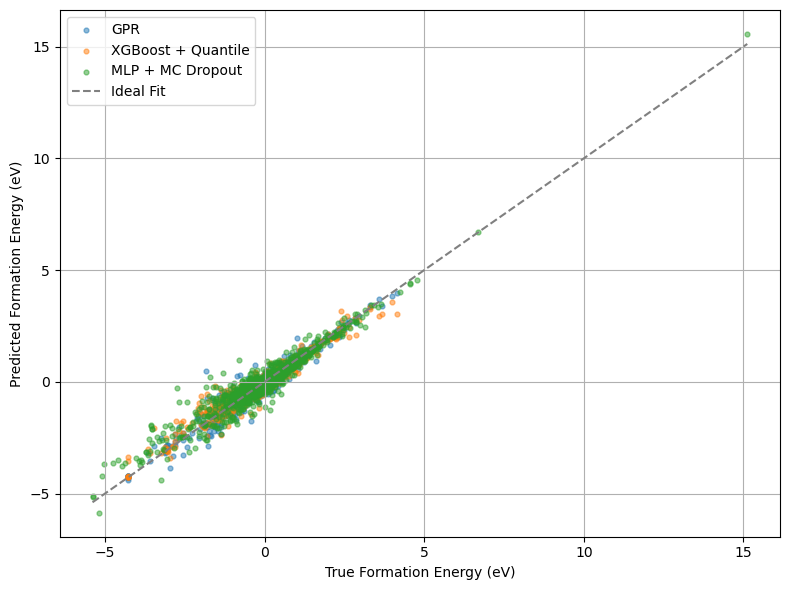

In [5]:
plt.figure(figsize=(8, 6))
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    plt.scatter(y_true, y_pred, alpha=0.5, s=12, label=model_name)

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray', label='Ideal Fit')
plt.xlabel('True Formation Energy (eV)')
plt.ylabel('Predicted Formation Energy (eV)')
# plt.title('True vs Predicted: Model Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


校准曲线（Calibration Curve）

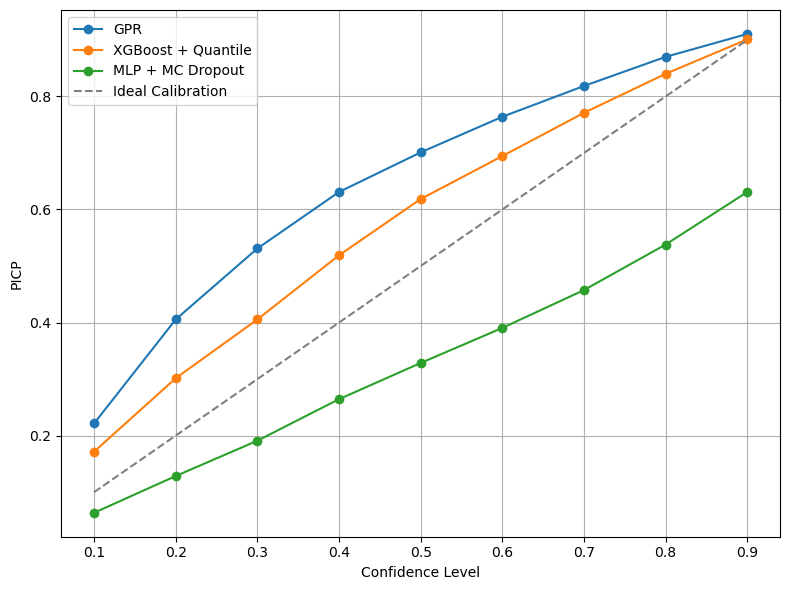

In [6]:
# 设置置信度等级
confidence_levels = np.linspace(0.1, 0.90, 9)  # 10% ~ 90%
z_values = [norm.ppf(0.5 + c / 2) for c in confidence_levels]

# 存储各模型的实际覆盖率
coverage_dict = {}

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    std = df['std']

    actual_coverage = []

    for z in z_values:
        lower = y_pred - z * std
        upper = y_pred + z * std
        covered = ((y_true >= lower) & (y_true <= upper)).astype(int)
        coverage = covered.mean()
        actual_coverage.append(coverage)

    coverage_dict[model_name] = actual_coverage

# 绘图
plt.figure(figsize=(8, 6))
for model_name, actual_coverage in coverage_dict.items():
    plt.plot(confidence_levels, actual_coverage, marker='o', label=model_name)

# 理想校准曲线
plt.plot(confidence_levels, confidence_levels, linestyle='--', color='gray', label='Ideal Calibration')

plt.xlabel('Confidence Level')
plt.ylabel('PICP')
# plt.title('Calibration Curves of Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Residual vs Std 散点图 + 相关性分析

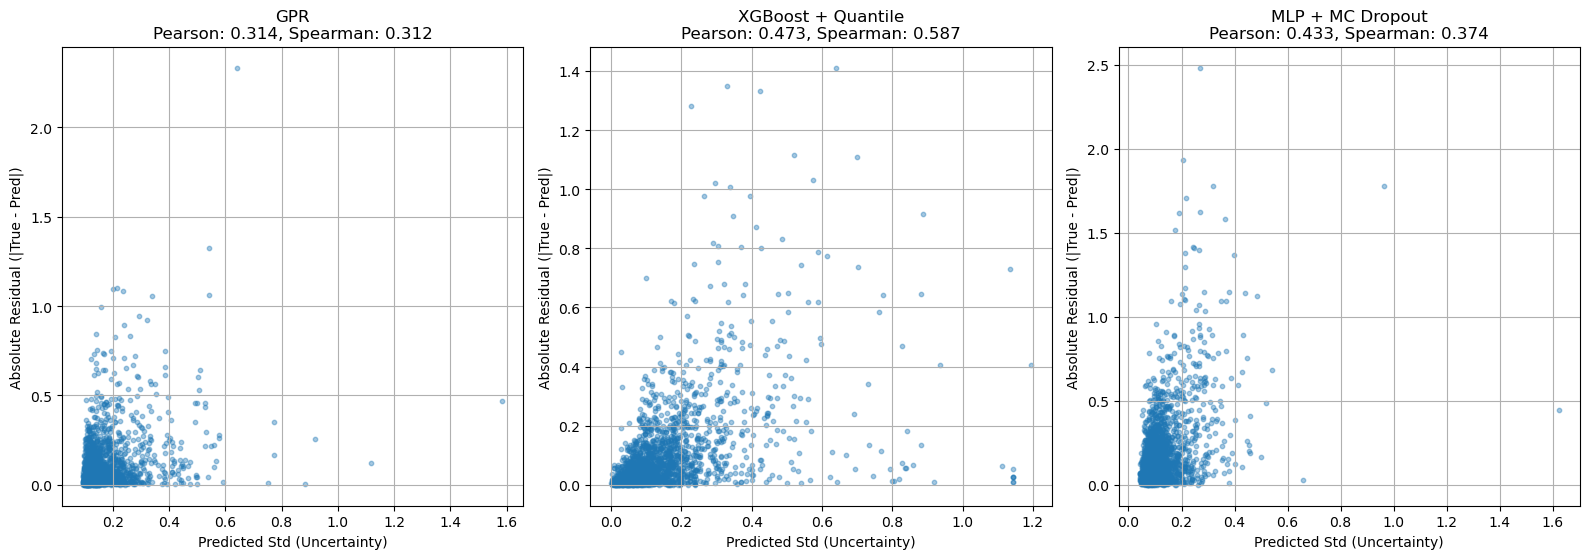

In [7]:
# 三个模型分别计算并绘图
plt.figure(figsize=(16, 6))

for i, (model_name, file_path) in enumerate(model_files.items()):
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    std = df['std']
    residual = np.abs(y_true - y_pred)

    # 相关性系数
    pearson_corr, _ = pearsonr(std, residual)
    spearman_corr, _ = spearmanr(std, residual)

    # 画图
    plt.subplot(1, 3, i + 1)
    plt.scatter(std, residual, alpha=0.4, s=10)
    plt.xlabel('Predicted Std (Uncertainty)')
    plt.ylabel('Absolute Residual (|True - Pred|)')
    plt.title(f"{model_name}\nPearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}")
    plt.grid(True)

# plt.suptitle("Residual vs Uncertainty Scatter Plots", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Boxplot of std

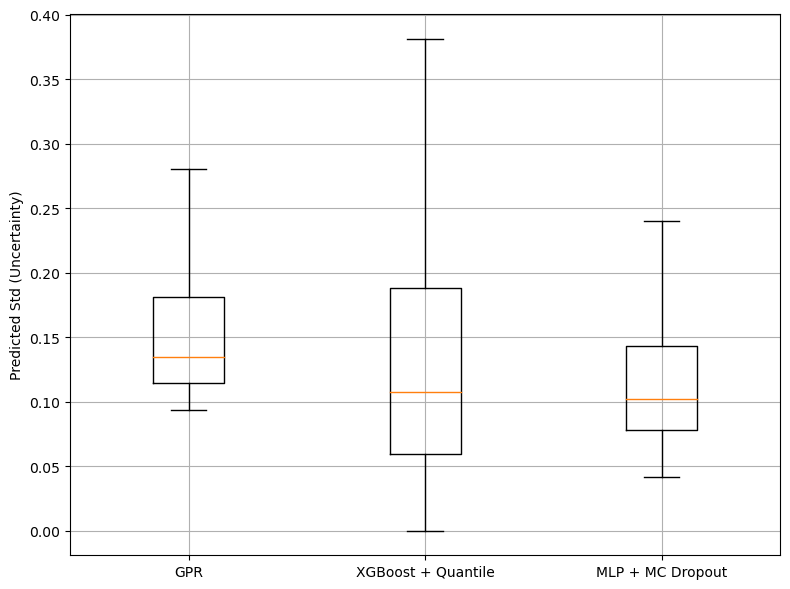

In [8]:
plt.figure(figsize=(8, 6))
std_data = []
model_labels = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    std_data.append(df['std'])
    model_labels.append(model_name)

plt.boxplot(std_data, labels=model_labels, showfliers=False)
plt.ylabel('Predicted Std (Uncertainty)')
# plt.title('Uncertainty Distribution across Models')
plt.grid(True)
plt.tight_layout()
plt.show()


锐度分析图（KDE）

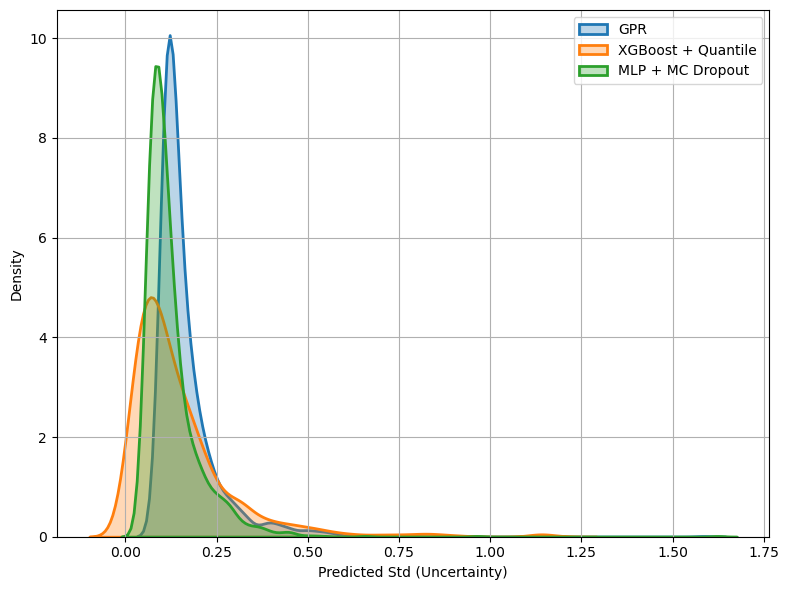

In [9]:
plt.figure(figsize=(8, 6))

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    std = df['std']
    sns.kdeplot(std, fill=True, alpha=0.3, label=model_name, linewidth=2)

plt.xlabel('Predicted Std (Uncertainty)')
plt.ylabel('Density')
# plt.title('Distribution of Predicted Sharpness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()